In [1]:
import json
import gensim
import pickle
import pandas as pd
import deepcut
pd.set_option('display.max_colwidth', -1)

C:\Users\Administrator\Anaconda3\envs\tensorflow\lib\site-packages\gensim\utils.py:1197: UserWarning: detected Windows; aliasing chunkize to chunkize_serial
  warnings.warn("detected Windows; aliasing chunkize to chunkize_serial")
Using TensorFlow backend.


# Load Word2Vec

In [2]:
model = gensim.models.Word2Vec.load("./wikisave/wiki.model")
df = pd.read_csv("./wikisave/wikidf.csv",encoding='utf-8')
df = df[['cluster','word']]
df.set_index('word',inplace=True)

# read python dict back from the file
pkl_file = open('./wikisave/dictionary.pkl', 'rb')
dic = pickle.load(pkl_file)
pkl_file.close()

pkl_file = open('./wikisave/freqdictionary.pkl', 'rb')
freqdic = pickle.load(pkl_file)
pkl_file.close()

# Import Twitter

In [3]:
filename = ['@KBank.json','@SCB_Thailand.json']
#Read JSON data into the datastore variable
def load(name):
    if name:
        with open(name, 'r') as f:
            datastore = json.load(f)
        return datastore[0]

def clean(tweet):
    name = tweet['user']['screen_name']
    if 'retweeted_status' in dir(tweet):
        try:
            return tweet['retweeted_status']['full_text'],name
        except:
            return tweet['retweeted_status']['text'],name
    else:
        try:
            return tweet['full_text'],name
        except:
            return tweet['text'],name
        
def cleanedtweets(tweets):
    a = []
    names = []
    for tweet in tweets:
        rv,name = clean(tweet)
        if not rv.startswith('RT'):
            a.append(rv)
            names.append(name)
    return a,names

def allload():
    datalist = []
    multinames = []
    for file in filename:
        print(file)
        data,names = cleanedtweets(load(file))
        datalist.append(data)
        multinames.append(names)
    return datalist, multinames

data,multinames = allload()

@KBank.json
@SCB_Thailand.json


# Gen Score

In [4]:
def genscorematrix(bow,maxscore):
    rv = pd.DataFrame(columns=['word','score'])
    df = pd.DataFrame()
    for word in bow:
        wordscore = df.from_records(model.wv.most_similar(positive=word,topn=10),columns=['word','score'])
        rv = rv.append(wordscore,ignore_index=True).append(pd.DataFrame([[word,1]], columns=['word','score']),ignore_index=True)
    rv.sort_values('score',inplace=True,ascending=False)
    rv.set_index('word',inplace=True)
    rv['score'] = rv['score'].apply(lambda x: x*maxscore)
    return rv

def score(l,scorematrix,name='',verbose=False):
    #l = deepcut.tokenize(comment)
    tot = 0
    for word in l:
        if word in scorematrix.index:
            tot += scorematrix.loc[word]['score'].max()
    if verbose == True:
        print(name,': ',tot)
    return tot

def printsummarydf(score1,score2,scoreagg,tweets,names,istweet=True):
    comments = tweets 
    summary = pd.DataFrame(
    {'Comment': comments,
     'Name': names})

    summary['Tokenize'] = summary['Comment'].apply(lambda x: deepcut.tokenize(x))
    summary['# of Words'] = summary['Tokenize'].apply(len)
    summary['Score1 (ยืม/กู้)'] = summary['Tokenize'].apply(lambda x: score(x,score1,verbose=False))
    summary['Score2 (ลงทุน)'] = summary['Tokenize'].apply(lambda x: score(x,score2,verbose=False))
    summary['General Score'] = summary['Tokenize'].apply(lambda x: score(x,scoreagg,verbose=False))

    summary.sort_values('General Score',ascending=False,inplace=True)
    summary.reset_index(inplace=True,drop=True)
    
    return summary

# Create Score

In [7]:
bow1= {'เงิน','ยืม','กู้','แบงค์','ฝาก','ผ่อน','ถอน'}
bow2 = {'หุ้น','กองทุน','ดอกเบี้ย','ลงทุน','พันธบัตร'}
generalterms = {'ธนาคาร','ออม','สมัคร','สนใจ','พาณิชย์','สอบถาม'}

score1 = genscorematrix(bow1,1)
score2 = genscorematrix(bow2,1)
scoreagg = genscorematrix(generalterms,0.66)
scoreagg = pd.concat([scoreagg,score1,score2])

In [6]:
KBank = printsummarydf(score1,score2,scoreagg,data[0],multinames[0])
SCB = printsummarydf(score1,score2,scoreagg,data[1],multinames[1])

In [7]:
KBank

,Comment,Name,Tokenize,# of Words,Score1 (ยืม/กู้),Score2 (ลงทุน),General Score
0,@KBank_Live เหล้าไม่ยุ่งมุ่งแต่ทำงานเก็บตังค์และฝากเงิน ฝากเงินเข้าธนาคาร โหลดแอพKPlus เงินปลอดภัยและยังได้ดอกเบี้ยด้วย พรรษานี้ฟินสุดๆๆ❤ #KBankLiveแจกNote8,BlackBlink48,"[@KBank_Live, , เหล้า, ไม่, ยุ่ง, มุ่ง, แต่, ทำ, งาน, เก็บ, ตังค์, และ, ฝาก, เงิน, , ฝาก, เงิน, เข้า, ธนาคาร, , โหลดแอพKPlus, , เงิน, ปลอด, ภัย, และ, ยัง, ได้, ดอกเบี้ย, ด้วย, , พรรษา, นี้, ฟิน, สุด, ๆ, ๆ, ❤, , #KBankLive, แจก, Note, 8]",43,5.524672,3.097246,6.660000
1,Retweeted KBank Live (@KBank_Live):\n\n#กสิกรไทย ลงนาม MOU เปิดตัวบัญชีเงินฝากพื้นฐานให้ผู้มีรายได้น้อยและผู้สูงอายุ ไม่มีเงินฝากขั้นต่ำในการเปิดและคงบัญชี รวมถึง ฝาก ถอน โอน... https://t.co/jqau5LaEpb,nanoninth,"[Retweeted, , KBank, Live, , (, @, KBank_Live, ), :\n\n, #กสิกร, ไทย, , ลง, นาม, , MOU, , เปิด, ตัว, บัญชี, เงิน, ฝาก, พื้นฐาน, ให้, ผู้, มี, ราย, ได้, น้อย, และ, ผู้, สูงอายุ, , ไม่, มี, เงิน, ฝาก, ขั้น, ต่ำ, ใน, การ, เปิด, และ, คง, บัญชี, , รวม, ถึง, , ฝาก, , ถอน, , โอน, ..., , https:, //t.co/jqau5LaEpb]",59,6.394174,1.049343,6.394174
2,@KBank_Live เหล้าไม่ยุ่ง มุ่งแต่ฝาก (ฝากเงินกับธนาคารกสิกร มีแต่ได้กับได้เอาเงินที่ไปซื้อเหล้ามาฝากกันดีกว่า) 💞💞 #KBankLiveแจกNote8 👏🏻👏🏻👏🏻👍🏻👍🏻,yoonath2000,"[@KBank_Live, , เหล้า, ไม่, ยุ่ง, , มุ่ง, แต่, ฝาก, , (, ฝาก, เงิน, กับ, ธนาคารกสิกร, , มี, แต่, ได้, กับ, ได้, เอา, เงิน, ที่, ไป, ซื้อ, เหล้า, มา, ฝาก, กัน, ดี, กว่า, ), , 💞, 💞, , #KBankLive, แจก, Note, 8, , 👏, 🏻, 👏, 🏻, 👏, 🏻, 👍, 🏻, 👍, 🏻]",52,5.943657,1.049343,5.943657
3,@KBank_Live เหล้าไม่ยุ่ง..มุ่งแต่หาเงินซื้อโทรศัพย์\n💨 📱💸 จะได้ ทั้งช็อป ทั้งโอน ทั้งฝาก ใน👉 #KBankLiveแจกNote8 ถ้าได้Note8 จะดีมากเลยจ้าา,gFspOD7bX95oxkf,"[@KBank_Live, , เหล้า, ไม่, ยุ่ง, .., มุ่ง, แต่, หา, เงิน, ซื้อ, โทรศัพย์\n, 💨, , 📱, 💸, , จะ, ได้, , ทั้ง, ช็อป, , ทั้ง, โอน, , ทั้ง, ฝาก, , ใน, 👉, , #KBankLive, แจก, Note, 8, , ถ้า, ได้, Note, 8, , จะ, ดี, มาก, เลย, จ้าา]",47,2.882791,0.524672,2.882791
4,@KBank_Live เหล้าไม่ยุ่ง มุ่งแต่ เก็บเงินออมลงบัญชีkbank เก็บไว้เผื่ออนาคต เพื่อการศึกษา ซื้อของที่อยากได้ และลงทุน เพื่อต่อยอด #KbankLiveแจกNote8,riyomori_,"[@KBank_Live, , เหล้า, ไม่, ยุ่ง, , มุ่ง, แต่, , เก็บ, เงิน, ออม, ลง, บัญชี, kbank, , เก็บ, ไว้, เผื่อ, อนาคต, , เพื่อ, การ, ศึกษา, , ซื้อ, ของ, ที่, อยาก, ได้, , , และ, ลง, ทุน, , เพื่อ, ต่อ, ยอด, , , , #KbankLive, แจก, Note, 8]",46,1.488617,1.060444,2.684389
5,@KBank_Live พรรษานี้ เหล้าไม่ยุ่ง มุ่งแต่ หาเงิน หา ทอง เอาไว้ไปฝาก KBank,asupakorn,"[@KBank_Live, , พรรษา, นี้, , เหล้า, ไม่, ยุ่ง, , มุ่ง, แต่, , หา, เงิน, , หา, , ทอง, , เอา, ไว้, ไป, ฝาก, , KBank]",25,2.455040,0.524672,2.455040
6,@KBank_Live โอนไม่ได้เหมือนเดิมครับ\nงั้นของกรุงเทพ @BangkokBankNEWS น่าจะเน่า\nโอนไปเบอร์ที่ผูกกับกสิกร &gt; โอนได้\nโอนไป citizenID ที่ผูกกับกรุงเทพ &gt; โอนไม่ได้ 😑,sornram9254,"[@KBank_Live, , โอน, ไม่, ได้, เหมือน, เดิม, ครับ\n, งั้น, ของ, กรุงเทพ, @, Bangkok, BankNEWS, , น่า, จะ, เน่า\n, โอน, ไป, เบอร์, ที่, ผูก, กับ, กสิกร, , &, gt, ;, , โอนได้\n, โอน, ไป, , citizenID, , ที่, ผูก, กับ, กรุงเทพ, , &, gt, ;, , โอน, ไม่, ได้, , 😑]",50,2.422651,0.000000,2.422651
7,@KBank_Live เหล้าไม่ยุ่ง...มุ่งโอนเงินเข้าเคแบงค์\nร่างกายแข็งแรง แถมมีเงินเหลืออู้ฟู่\n#KBankLiveแจกNote8,mniriz,"[@KBank_Live, , เหล้า, ไม่, ยุ่ง, ..., มุ่ง, โอน, เงิน, เข้า, เคแบงค์\n, ร่างกาย, แข็งแรง, , แถม, มี, เงิน, เหลืออู้ฟู่\n, #KBankLive, แจก, Note, 8]",22,2.394174,1.049343,2.394174
8,"@KBank_Live ธนาคารจำกัดสิทธิ์การได้รับเงินคืน (Cash back) สำหรับลูกค้า 90,000 คนแรกที่ทำรายการในระหว่างวันที่ 30 พฤษภาคม 2561 เวลา 24.00 น. ถึงวันที่ 25 กันยายน 2561 เวลา 24.00 น. ตามข้อมูลที่ปรากฏในระบบของธนาคารเท่านั้น",nuisaran,"[@KBank_Live, , ธนาคาร, จำกัด, สิทธิ์, การ, ได้, รับ, เงิน, คืน, , (, Cash, , back, ), , สำหรับ, ลูกค้า, , 90, ,, 000, , คน, แรก, ที่, ทำ, รายการ, ใน, ระหว่าง, วัน, ที่, , 30, , พฤษภาคม, , 2561, , เวลา, , 24, ., 00, , น., , ถึง, วัน, ที่, , 25, , กันยายน, , 2561, , เวลา, , 24, ., 00, , น., , ตาม, ข้อมูล, ที่, ปรากฏ, ใน, ระบบ, ของ, ธนาคาร, เท่า, นั้น]",76,1.000000,1.571134,2.320000
9,"@KBank_Live "" เหล้าไม่ยุ่ง มุ่งแต่ออม

In [8]:
SCB

,Comment,Name,Tokenize,# of Words,Score1 (ยืม/กู้),Score2 (ลงทุน),General Score
0,คุณพระคุณเจ้าช่วย! เพิ่งเคยใช้บริการกดเงินไม่ใช้บัตรของ @scb_thailand ไวมากกกกกกก 30 วินาทีได้เงินแล้ว อันนี้ยอม นับถือๆๆ โอนเงินมา SCB โดยพลัน ลาทีค่าธรรมเนียม ATM #BizKlass,lekmonchai,"[คุณพระคุณ, เจ้าช่วย, !, , เพิ่ง, เคย, ใช้, บริการ, กด, เงิน, ไม่, ใช้, บัตร, ของ, , @scb_thailand, , ไว, มาก, กกกกกก, , 30, , วินาที, ได้, เงิน, แล้ว, , อัน, นี้, ยอม, , นับ, ถือ, ๆ, ๆ, , โอน, เงิน, มา, , SCB, , โดย, พลัน, , ลาที, ค่า, ธรรมเนียม, , ATM, , #BizKlass]",53,3.394174,2.149494,3.969653
1,@scb_thailand สวัสดีค่ะ อยากสอบถามว่า ใบเสร็จค่างวดรถนี่ทางธนาคารออกให้ทุกเดือนมั้ยคะ นี่จ่ายไป2งวดแล้ว ใบเสร็จยังไม่มาทั้ง2งวด จนวันที่5 นี้จะต้องจ่ายอีกงวดแล้วค่ะ หรือส่งมาแล้วค้างอยู่ไปรษณีย์คะ,peawjung,"[@scb_thailand, , สวัสดี, ค่ะ, , อยาก, สอบถาม, ว่า, , ใบ, เสร็จ, ค่างวด, รถ, นี่, ทาง, ธนาคาร, ออก, ให้, ทุก, เดือน, มั้ย, คะ, , นี่, จ่าย, ไป, 2, งวด, แล้ว, , ใบ, เสร็จ, ยัง, ไม่, มา, ทั้ง, 2, งวด, , , จน, วัน, ที่, 5, , , นี้, จะ, ต้อง, จ่าย, อีก, งวด, แล้ว, ค่ะ, , , หรือ, ส่ง, มา, แล้ว, ค้าง, อยู่, ไปรษณีย์คะ]",63,0.000000,2.133867,2.930636
2,สวัสดีค่ะ @scb_thailand อยากทราบว่าหักเงินอัตโนมัติคิออะไรหรือคะ พอดีตอนมัครพวก easy net เห็นพี่พนักงานบอกว่าไม่มีค่าใช้จ่ายอะไร แล้วสามารถขอเงินคืนได้หรือเปล่าคะ ขอบคุณค่ะ https://t.co/vy0z22IsSs,macherieishere,"[สวัสดี, ค่ะ @scb_thailand, , อยาก, ทราบ, ว่า, หัก, เงิน, อัตโนมัติ, คิอ, อะไร, หรือ, คะ, , พอดี, ตอน, มัครพวก, , easy, , net, , เห็น, พี่, พนักงาน, บอก, ว่า, ไม่, มี, ค่า, ใช้จ่าย, อะไร, , แล้ว, สามารถ, ขอ, เงิน, คืน, ได้, หรือ, เปล่า, คะ, , ขอบคุณ, ค่ะ, , https://t.co/vy0z22IsSs]",47,2.000000,1.624822,2.903332
3,@kittagon @KTB_Care @scb_thailand โอนผ่านพร้อมเพย์หรือเปล่าคะ เมื่อวานแม่เราโอนจากไทยพาณิชย์ไปกสิกร เงินไม่เข้าลอยกลางอากาศ โทรแจ้งไปวันนี้ถึงเข้าให้เรียบร้อยค่ะ,Funiiza,"[@kittagon @KTB_Care @scb_thailand , โอน, ผ่าน, พร้อม, เพย์, หรือ, เปล่า, คะ, , เมื่อ, วาน, แม่, เรา, โอน, จาก, ไทย, พาณิชย์, ไป, กสิกร, , เงิน, ไม่, เข้า, ลอยกลาง, อากาศ, , โทร, แจ้ง, ไป, วัน, นี้, ถึง, เข้า, ให้, เรียบร้อย, ค่ะ]",36,1.788348,0.524672,2.448348
4,@scb_thailand แล้วถ้าแจ้งเรื่องทางธนาคารว่าเราจะเปลี่ยนชื่อที่ใช้เป็นภาษาอังกฤษในการทำธุรกรรมทางการเงินทุกช่องทาง แบบนั้นได้ไหมคะ,sinsuky,"[@scb_thailand, , แล้ว, ถ้า, แจ้ง, เรื่อง, ทาง, ธนาคาร, ว่า, เรา, จะ, เปลี่ยน, ชื่อ, ที่, ใช้, เป็น, ภาษา, อังกฤษ, ใน, การ, ทำ, ธุรกรรม, ทาง, การ, เงิน, ทุก, ช่องทาง, , แบบ, นั้น, ได้, ไหม, คะ]",33,1.000000,1.047903,1.660000
5,@scb_thailand สอบถามเเรื่องใบแจ้งยอดบัตรเครดิต ธนาคารไม่มีการแจ้งตามที่เลือกไว้ คือผ่านทางอีเมล์,Dkt_xXTheRoBiN,"[@scb_thailand, , สอบถาม, เเรื่อง, ใบ, แจ้ง, ยอด, บัตร, เครดิต, , ธนาคาร, ไม่, มี, การ, แจ้ง, ตาม, ที่, เลือก, ไว้, , คือ, ผ่าน, ทาง, อีเมล์]",24,0.000000,0.523231,1.520546
6,@scb_thailand จะเปลี่ยนได้เลยปะคะ เมื่อวาน CC บอกว่าถ้าจะอัพต้องไปสมัครใหม่เอง 😑\nคือไม่ได้จะเอาอีกบัญชีบัตรนะ\nถ้าเปลี่ยนให้เลยก็จะใช้\nแต่ถ้าไม่ได้ก็จะส่งคืนบัตรนี้ค่ะ\nมันไม่ใช่การอัพเกรด รู้สึกแย่อะ,rzranya,"[@scb_thailand, , จะ, เปลี่ยน, ได้, เลย, ปะคะ, , เมื่อ, วาน, , CC, , บอก, ว่า, ถ้า, จะ, อัพ, ต้อง, ไป, สมัคร, ใหม่, เอง, , 😑\n, คือ, ไม่, ได้, จะ, เอา, อีก, บัญชี, บัตร, นะ\n, ถ้า, เปลี่ยน, ให้, เลย, ก็, จะ, ใช้\n, แต่, ถ้า, ไม่, ได้, ก็, จะ, ส่ง, คืน, บัตร, นี้, ค่ะ\n, มัน, ไม่, ใช่, การ, อัพเกรด, , รู้สึก, แย่อะ]",60,0.455040,0.000000,1.442892
7,@scb_thailand โอนเงินผ่านscb easy แต่ยอดไม่เย้าบัญชีปลานทาง แจ้งเรื่องไปแล้วแต่อยากเร่งดำเนินการให้เร็วที่สุด แจ้งข้อมูลเพิ่มเติมไปทางDM แล้ว ตอบกลับด้วยนะคะ,qmnvx_,"[@scb_thailand, , โอน, เงิน, ผ่าน, scb, , easy, , แต่, ยอด, ไม่, เย้า, บัญชี, ปลาน, ทาง, , แจ้ง, เรื่อง, ไป, แล้ว, แต่, อยาก, เร่ง, ดำเนินการ, ให้, เร็ว, ที่สุด, , แจ้ง, ข้อมูล, เพิ่มเติม, ไป, ทาง, DM, , แล้ว, , ตอบ, กลับ, ด้วย, นะ, คะ]",43,1.394174,0.524672,1.394174
8,@scb_thailand เราเดินทางกลับจากต่างจังหวัด เราเลยแวะกดเงิน ตอนนี้เราผ่านตู้นั้นมานานมากแล้ว เราไม่สามารถทราบรายละเอียดของตู้นั้นได้ค่ะ ถ้าเห็นใจเรา โอน 20 บาทที่เราเสียไปคืนให้เราหน่อยได้ไหมอ่ะ 😍😘💋,impatcharanan,"[@scb_thailand, , เรา, เดินทาง, กลับ, จาก, ต่า

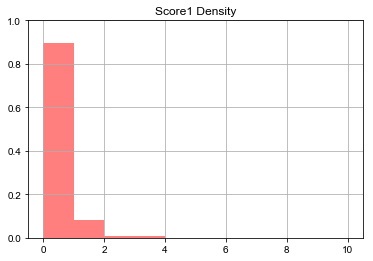

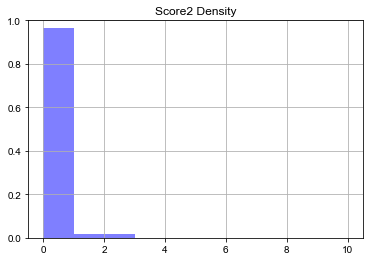

In [60]:
import matplotlib.pyplot as plt

def plotter(df):
    fig, ax = plt.subplots()
    ax.set_ylim([0,1])
    df.hist(ax=ax,bins=10,column='Score1 (ยืม/กู้)',range=(0,10),density=True,color='red',alpha=0.5)
    plt.title('Score1 Density')
    fig2, ax2 = plt.subplots()
    ax2.set_ylim([0,1])

    df.hist(ax=ax2,bins=10,column='Score2 (ลงทุน)',range=(0,10),density=True,color='blue',alpha=0.5)
    plt.title('Score2 Density')
    fig.savefig('Scores21.png')
    fig2.savefig('Scores22.png')
    plt.show()

#plotter(KBank)
plotter(SCB)